# fft score cam implementation


### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import wandb
import pickle
#from PIL import Image
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import transform
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import cv2
from plotting_utils import RF_Visualizer
import pandas as pd
from scipy.fft import fft, ifft,fftshift
import os
import math
from scipy import signal

cur_dir = os.getcwd()
print(cur_dir)



/home/sagetrudeau/Projects/XAI/RF-Models-CAM-Evaluation


### Load Data

In [2]:
if __name__ == "__main__":
    from model import Baseline_CNN1D
    from dataset_tprime import TPrimeDataset
    import argparse
    from scipy.io import loadmat


    # seqs = {}
    # with open("/home/sagetrudeau/Datasets/ORACLE/mat_files/raw/train.pkl", "rb") as f:#Oracle
    # #with open("/raid/backup_storage_oldDGX/LORA/Year_1_outdoor/outdoor_dataset_1/mat_files/raw/train.pkl", "rb") as f:
    #     file_dict = pickle.load(f)
    # filenames = file_dict["files"]
    # print(filenames)
    # for i, name in enumerate(filenames):
    #     #print(i, len(filenames))
    #     seqs[name] = loadmat(name)["f_sig"][0]
    # #dataset = InDistributionTestDataset(seqs,"val")
    # dataset = InDistributionTestDatasetContinuous(seqs, "val")
    # #dataset = InDistributionTrainDataset(seqs)
    # train_dataset = InDistributionTrainDataset(seqs)
    # del seqs
    args=argparse.Namespace()
    args.protocols = ['802_11ax', '802_11b_upsampled', '802_11n', '802_11g']
    args.noise = True
    args.snr_db = [30]
    args.raw_path = "/home/sagetrudeau/Projects/t-prime/data/DATASET1_1"
    args.slicelen = 512
    args.overlap_ratio = 0.0
    args.postfix = ''
    args.raw_data_ratio = 1.0
    args.channel = None
    args.out_mode = 'real'
    args.worker_batch_size = 512

    ds_test = TPrimeDataset(args.protocols,
                          ds_path=args.raw_path,
                          ds_type='test',
                          snr_dbs=args.snr_db,
                          slice_len=args.slicelen,
                          slice_overlap_ratio=float(args.overlap_ratio),
                          raw_data_ratio=args.raw_data_ratio,
                          file_postfix=args.postfix,
                          override_gen_map=False,    # it will use the same as above call
                          apply_wchannel=args.channel,
                          apply_noise=args.noise,
                          out_mode=args.out_mode)
    dataloader = DataLoader(ds_test, batch_size=args.worker_batch_size, shuffle=False)
    dataloader_aug = DataLoader(ds_test, batch_size=args.worker_batch_size, shuffle=False)
    print(dataloader.dataset[0])


(array([[ 0.83196074, -0.65662307,  0.32264539, ..., -0.65761225,
        -1.12059288, -0.67295217],
       [ 0.50358201,  1.13937468, -0.01223459, ..., -1.17871891,
         0.24539864, -0.60937985]]), 3)


### Load model


In [3]:

#t-prime
PATH = './results/t-prime/SNR30/'
Nclass = 4
num_channels = 2
num_feats = 1
slice_len = 512

device = torch.device('cpu')
print(device)
model = Baseline_CNN1D(classes=Nclass, numChannels=num_channels, slice_len=slice_len)
checkpoint = torch.load(cur_dir+"/model/model.baseline_cnn1d.nochan.range.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device) # reload the model on the appropriate device
model.device = device
model.eval()    # set the evaluation mode
print(model,next(model.parameters()).device)
print(model.device)




cpu
Baseline_CNN1D(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(1,))
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (feature_extractor): ModuleList(
    (0): Conv1d(2, 64, kernel_size=(7,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16000, out_features=256, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
) cpu
cpu


### Experimenting with TSNE

In [29]:
from sklearn.manifold import TSNE
import itertools
import cuml
# Function to extract features from the last fully connected layer before softmax
def extract_features(model, data_loader, aug_idx=None):
    features = []
    labels = []
    batches_to_run=5
    i=0
    target_layer_to_extract = "relu3"
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            batch_size = len(data)
            print("batch_idx, ", batch_idx)
            # Ensure data is converted to float and moved to the correct device
            data = data.float().to(model.device)  # Convert data to float here
            for name, layer in model.named_children():
                #initial_layer_flag =True
                print(f"Running layer: {name}",layer)
                #handle any special case layers to skip or transform as appropriate for your model
                if "LayerNorm" in name:
                    continue
                if "feature_extractor" in name:
                    continue
                if "fc1" in name:
                    data= torch.flatten(data, 1)
                data=layer(data)
                
                #break out after target layer reached
                if target_layer_to_extract in name:
                    break
                
                
            # # Get the output from the last fully connected layer (fc1)
            # x = model.conv1(data)
            # x = model.relu1(x)
            # x = model.maxpool1(x)
            # x = model.conv2(x)
            # x = model.relu2(x)
            # x = model.maxpool2(x)
            # x = torch.flatten(x, 1)
            # x = model.fc1(x)
            # x = model.relu3(x)
            # # x= model.fc2(x)
            # # x=model.logSoftmax(x)
          
            features.append(data.cpu().numpy())
            labels.append(target.numpy())
            if i >= batches_to_run:
                break
            i+=1
    print(len(features))
    #run augmented sample as well if available
    if aug_idx is not None:
        data, target = data_loader.dataset[aug_idx]
        # Convert data to torch tensor and ensure it has the correct shape
        if isinstance(data, np.ndarray):
            data = torch.from_numpy(data).float()
        else:
            data = data.float()

        # Check the device of the model
        device = next(model.parameters()).device
        # Move the tensor to the same device as the model
        data = data.to(device)

        # Ensure the input shape matches the model's expected dimensions
        if len(data.shape) == 2:
            data = data.unsqueeze(0)
        elif len(data.shape) == 1:
            data = data.unsqueeze(0).unsqueeze(0)

        # Get the output from the last fully connected layer (fc1)
        x = model.conv1(data)
        x = model.relu1(x)
        x = model.maxpool1(x)
        x = model.conv2(x)
        x = model.relu2(x)
        x = model.maxpool2(x)
        x = torch.flatten(x, 1)
        x = model.fc1(x)
        x = model.relu3(x)
        # x = model.fc2(x)
        # x = model.logSoftmax(x)
        
        features.append(x.cpu().detach().numpy())
        labels.append(target.numpy() if isinstance(target, torch.Tensor) else np.array([target]))
        print("after aug",len(features),len(features[-1]),len(features[-2]))
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

features, labels = extract_features(model, dataloader)
print(features.shape,labels.shape)

fig, ax = plt.subplots(1, 3, figsize=(20,7), constrained_layout=True)
for c, per in zip(itertools.count(), [5, 30, 50]):
    tsne = cuml.manifold.TSNE(n_components=2,
                perplexity=per,
                n_neighbors=per*4)
    tsne = tsne.fit_transform(features)
    print(len(tsne))
    scatter = ax[c].scatter(tsne[:-1, 0], tsne[:-1, 1], c=labels[:-1], cmap='tab10', s=0.3)
    scatter = ax[c].scatter(tsne[-1, 0], tsne[-1, 1], c=labels[-1], cmap='tab10',marker='*', edgecolors='k', s=50)
    ax[c].set_title(f'Perplexity: {per}', fontsize=16)    

fig.suptitle('t-SNE Dimensionality reduction', fontweight='bold', fontsize=25)
cbar = fig.colorbar(scatter, boundaries=np.arange(11)-0.5, location='right')
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.show()

batch_idx,  0
Running layer: norm LayerNorm((512,), eps=1e-05, elementwise_affine=True)
Running layer: conv1 Conv1d(2, 64, kernel_size=(7,), stride=(1,))
Running layer: relu1 ReLU()
Running layer: maxpool1 MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Running layer: conv2 Conv1d(64, 128, kernel_size=(3,), stride=(1,))
Running layer: relu2 ReLU()
Running layer: maxpool2 MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Running layer: feature_extractor ModuleList(
  (0): Conv1d(2, 64, kernel_size=(7,), stride=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (4): ReLU()
  (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Running layer: fc1 Linear(in_features=16000, out_features=256, bias=True)
Running layer: relu3 ReLU()
batch_idx,  1
Running layer: norm LayerNorm((512,), eps=1e-05, elementwise_af

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 64

Checking layer: norm
Checking layer: conv1
Checking layer: relu1
Checking layer: maxpool1
Checking layer: conv2
Checking layer: relu2
Checking layer: maxpool2
Checking layer: feature_extractor
Checking layer: fc1
Checking layer: relu3
Checking layer: fc2
Checking layer: logSoftmax
batch_idx,  0
batch_idx,  1
batch_idx,  2
batch_idx,  3
batch_idx,  4
batch_idx,  5
6
after aug 7 1 512
Original features shape: (3073, 256) Labels shape: (3073,) [[-0.2108737   0.12269036 -0.6566795  ...  0.57578808 -0.62061013
  -0.85518668]
 [-0.25033897 -0.88064752  0.07658283 ...  0.00847954  0.52086923
  -0.44588898]]
Shape of inputs: (2, 512)
Model is on device: cpu
Original outputs shape: (1, 4)
Original prediction: [[  0.       -17.30464  -23.118944 -56.471718]]
True label: 2
Shape of inputs: (2, 512)
Augmented output: [[  0.       -23.286392 -19.294323 -53.014805]]
Original prediction: 0
Augmented prediction: 0
Checking layer: norm
Checking layer: conv1
Checking layer: relu1
Checking layer: maxpool1

/home/sagetrudeau/Projects/XAI/xai_venv/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


label debug 2 2
label debug 2 2
[W] [11:15:06.127709] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [11:15:07.498236] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
label debug 2 2


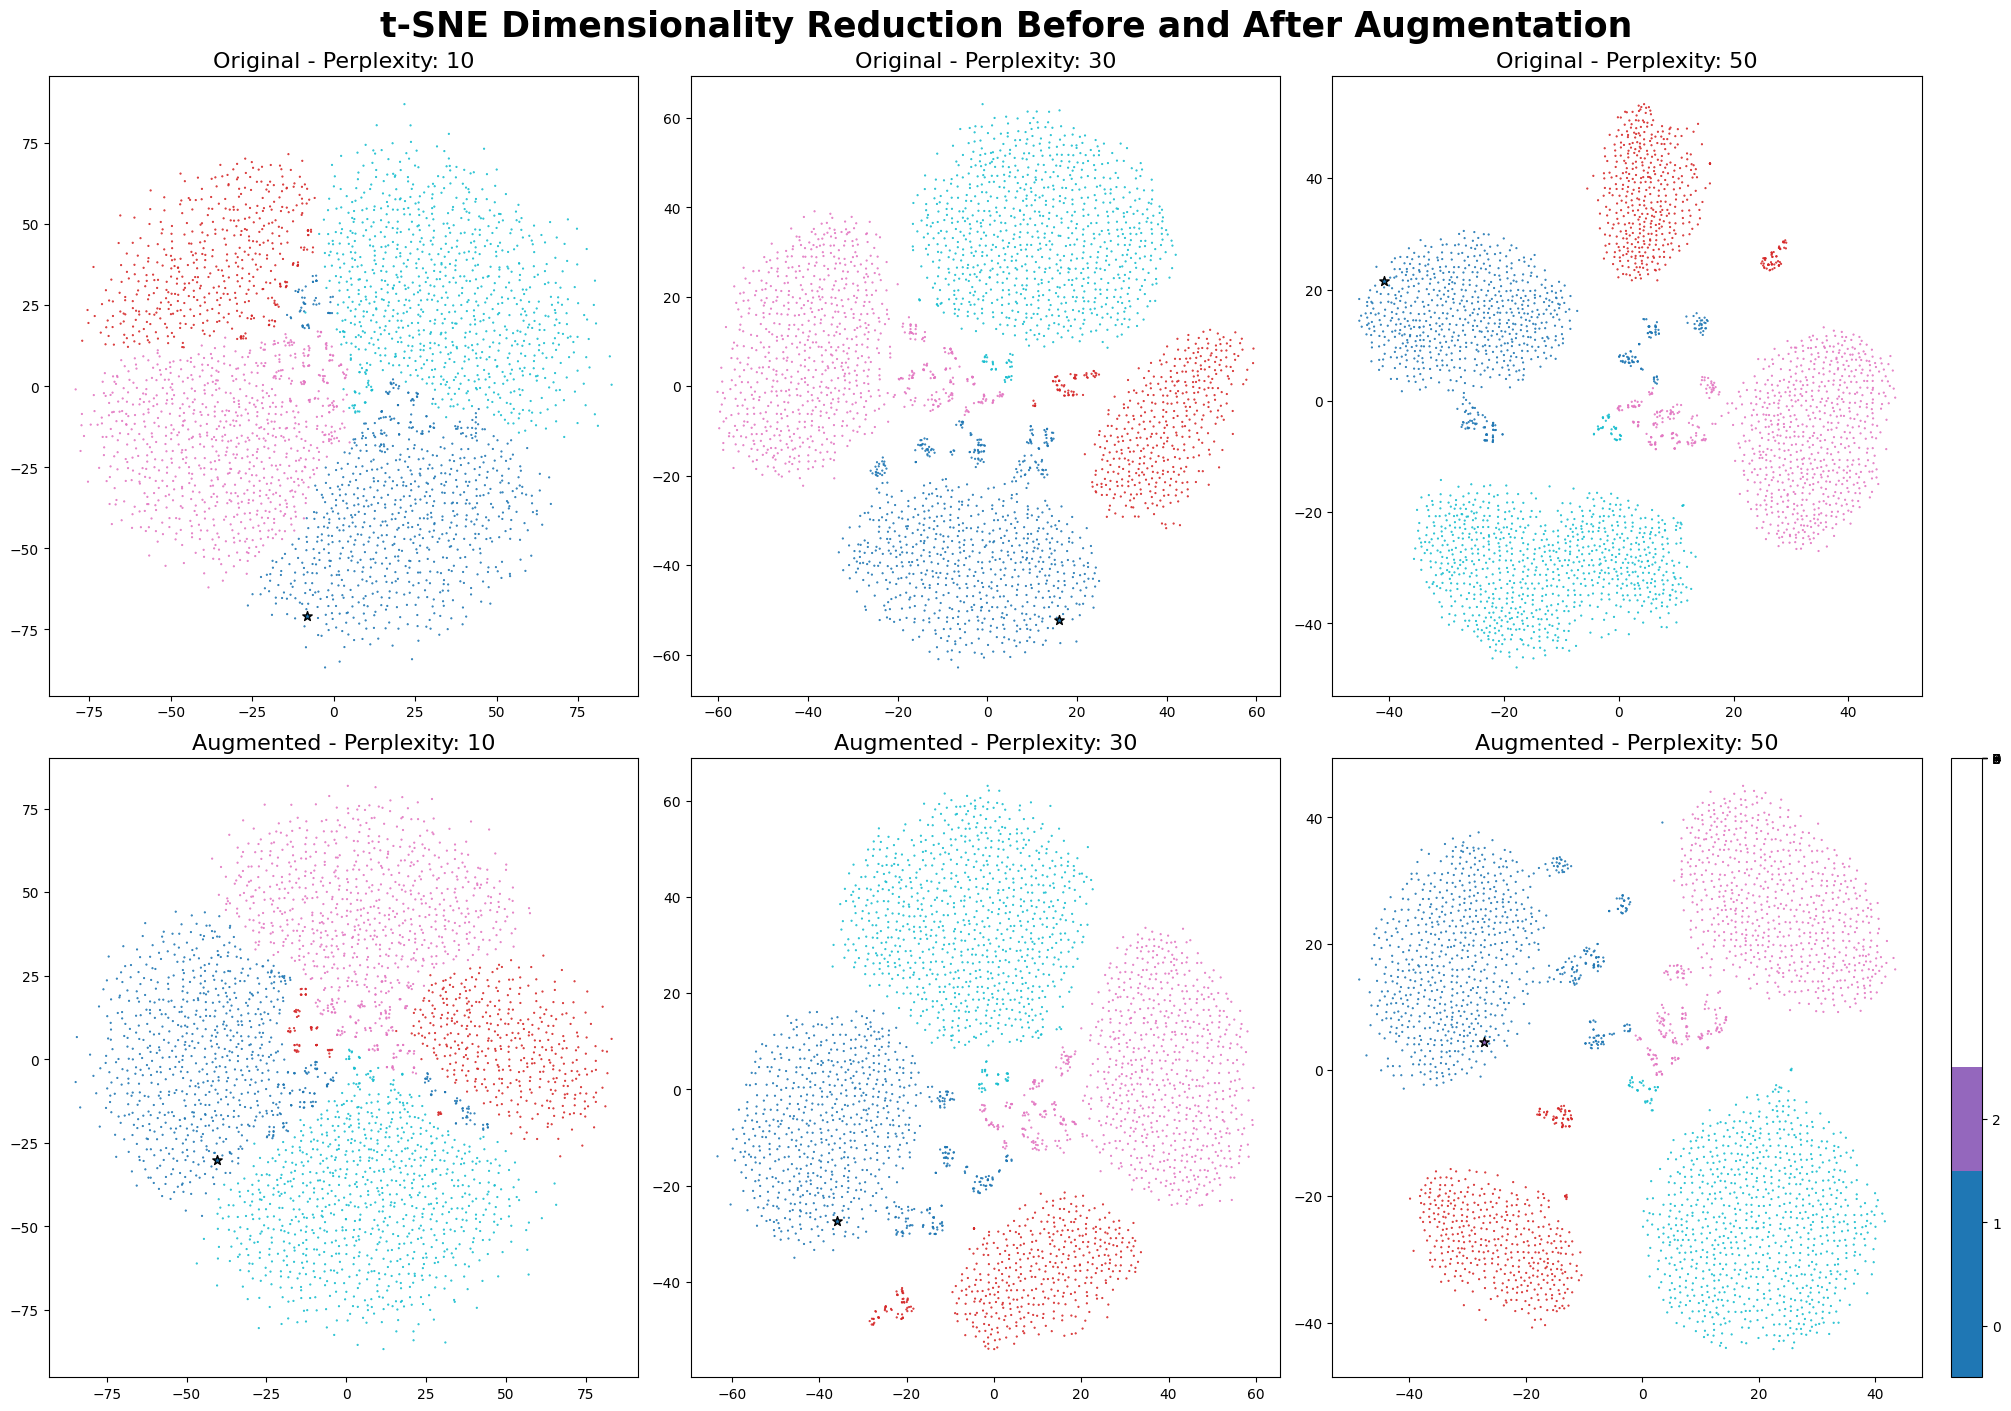

In [23]:
from collections import Counter

# Function to augment the last sample in the dataloader by replacing it with noise of equal power
def augment_sample(model, augemnted_dataloader,aug_idx):
    # Access the dataset directly from the dataloader
    dataset = augemnted_dataloader.dataset

    # Extract the last input and label
    inputs, labels = dataset[aug_idx]
    aug_inputs = inputs.copy()

    # Print the shape and values of the inputs
    #print("Original numpy array values:")
    #print(inputs)
    print(f"Shape of inputs: {inputs.shape}")

    # Convert numpy array to torch tensor
    slice_of_trans = torch.from_numpy(inputs).float()

    # Check the device of the model
    device = next(model.parameters()).device
    print(f"Model is on device: {device}")

    # Move the tensor to the same device as the model
    slice_of_trans = slice_of_trans.to(device)

    # Ensure the input shape matches the model's expected dimensions
    if len(slice_of_trans.shape) == 2:
        slice_of_trans = slice_of_trans.unsqueeze(0)
    #print("og",slice_of_trans)
    # Run the model prediction
    original_outputs = model(slice_of_trans).detach().cpu().numpy()
    print(f"Original outputs shape: {original_outputs.shape}")
    print(f"Original prediction: {original_outputs}")
    print(f"True label: {labels}")
    
    #augment a signal in signal_cache
    dataset.augment_signal_cache_item(aug_idx)
    # Extract the last input and label
    aug_inputs, aug_labels = dataset[aug_idx]
    # Run predictions after augmentation for verification
    aug_slice_of_trans = torch.from_numpy(aug_inputs).float()
    aug_slice_of_trans = aug_slice_of_trans.to(device)
    if len(aug_slice_of_trans.shape) == 2:
        aug_slice_of_trans = aug_slice_of_trans.unsqueeze(0)
    #print("augmented",aug_slice_of_trans)
    augmented_outputs = model(aug_slice_of_trans).detach().cpu().numpy()
    original_prediction = np.argmax(original_outputs, axis=1)[-1]
    augmented_prediction = np.argmax(augmented_outputs, axis=1)[-1]
    # Print the shape and values of the inputs
    #print("Augmented numpy array values:")
    #print(aug_inputs)
    print(f"Shape of inputs: {aug_inputs.shape}")

    print(f"Augmented output: {augmented_outputs}")
    print("Original prediction:", original_prediction)
    print("Augmented prediction:", augmented_prediction)

    # # Update the dataset with the modified 
    # #dataset = list(dataset)
    
    # dataset.augment_signal_cache_item(last_index, aug_inputs)
    # check_input, label = dataset[last_index]
    # print(check_input)
    # # Create a new dataloader with the modified dataset
    # #new_dataloader = DataLoader(dataset, batch_size=dataloader.batch_size, shuffle=False)
    
    return augemnted_dataloader

# Function to plot t-SNE with and without augmentation
def plot_tsne_with_augmentation(model, dataloader, dataloader_aug, aug_idx):
    # Extract features and labels from the original data
    features, labels = extract_features(model, dataloader,aug_idx)
    og_inputs, og_labels = dataloader.dataset[aug_idx]
    print("Original features shape:", features.shape, "Labels shape:", labels.shape,og_inputs)

    # Augment the last sample in the dataloader
    dataloader_aug = augment_sample(model,dataloader_aug,aug_idx)
    # Extract features and labels from the augmented data
    augmented_features, augmented_labels = extract_features(model, dataloader_aug,aug_idx)
    aug_inputs, aug_labels = dataloader_aug.dataset[aug_idx]
    print("Augmented features shape:", augmented_features.shape, "Labels shape:", augmented_labels.shape, aug_inputs)

    fig, ax = plt.subplots(2, 3, figsize=(20, 14), constrained_layout=True)
    
    for c, per in zip(itertools.count(), [10,30,50]):
        # Original t-SNE
        tsne = cuml.manifold.TSNE(n_components=2, perplexity=per, n_neighbors=per*4)
        tsne_result = tsne.fit_transform(features)
        mapped_aug_idx = len(tsne_result)-1
        # Plot all points except the one at mapped_aug_idx
        scatter = ax[0, c].scatter(tsne_result[np.arange(len(tsne_result)) != mapped_aug_idx, 0], 
                                tsne_result[np.arange(len(tsne_result)) != mapped_aug_idx, 1], 
                                c=labels[np.arange(len(labels)) != mapped_aug_idx], cmap='tab10', s=0.3)
        # Plot the specific index
        scatter = ax[0, c].scatter(tsne_result[mapped_aug_idx, 0], tsne_result[mapped_aug_idx, 1], 
                                c=[labels[mapped_aug_idx]], cmap='tab10', marker='*', edgecolors='k', s=50)
        ax[0, c].set_title(f'Original - Perplexity: {per}', fontsize=16)
        
        # Augmented t-SNE
        tsne_augmented = cuml.manifold.TSNE(n_components=2, perplexity=per, n_neighbors=per*4)
        tsne_augmented_result = tsne_augmented.fit_transform(augmented_features)
        # Plot all points except the one at mapped_aug_idx
        scatter = ax[1, c].scatter(tsne_augmented_result[np.arange(len(tsne_augmented_result)) != mapped_aug_idx, 0], 
                                tsne_augmented_result[np.arange(len(tsne_augmented_result)) != mapped_aug_idx, 1], 
                                c=augmented_labels[np.arange(len(augmented_labels)) != mapped_aug_idx], cmap='tab10', s=0.3)
        # Plot the specific index
        scatter = ax[1, c].scatter(tsne_augmented_result[mapped_aug_idx, 0], tsne_augmented_result[mapped_aug_idx, 1], 
                                c=[augmented_labels[mapped_aug_idx]], cmap='tab10', marker='*', edgecolors='k', s=50)
        ax[1, c].set_title(f'Augmented - Perplexity: {per}', fontsize=16)
        print("label debug", labels[mapped_aug_idx],augmented_labels[mapped_aug_idx])
    
    fig.suptitle('t-SNE Dimensionality Reduction Before and After Augmentation', fontweight='bold', fontsize=25)
    cbar = fig.colorbar(scatter,boundaries=np.arange(4)-0.5,location='right')
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(np.arange(10))
    plt.show()


dataloader = DataLoader(ds_test, batch_size=args.worker_batch_size, shuffle=False)
dataloader_aug = DataLoader(ds_test, batch_size=args.worker_batch_size, shuffle=False)
aug_idx = 10000
plot_tsne_with_augmentation(model, dataloader,dataloader_aug, aug_idx)
